# FD PARAMETER COMPARISON (ON VADERE DATASET)

In [1]:
import os
os.chdir(os.path.pardir)

In [2]:
from utilities import *

In [3]:
data_path = "../data/vadere_corridor_100"

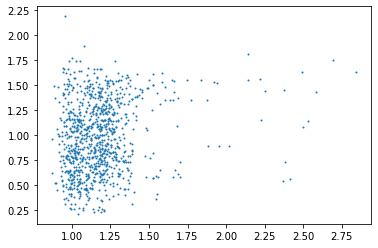

In [6]:
# plot vadere dataset
fd_data, fd_targets = read_dataset(data_path, fd_training=True)
plt.scatter(fd_data, fd_targets, s=1)  # original data
plt.show()

### FIT FD MODEL ON OBSERVATIONS

Epoch 1/50
31/31 - 1s - loss: 0.3075 - 560ms/epoch - 18ms/step
Epoch 2/50
31/31 - 0s - loss: 0.2127 - 428ms/epoch - 14ms/step
Epoch 3/50
31/31 - 0s - loss: 0.1599 - 425ms/epoch - 14ms/step
Epoch 4/50
31/31 - 0s - loss: 0.1362 - 426ms/epoch - 14ms/step
Epoch 5/50
31/31 - 0s - loss: 0.1284 - 449ms/epoch - 14ms/step
Epoch 6/50
31/31 - 0s - loss: 0.1279 - 464ms/epoch - 15ms/step
Epoch 7/50
31/31 - 0s - loss: 0.1278 - 461ms/epoch - 15ms/step
Epoch 8/50
31/31 - 1s - loss: 0.1278 - 600ms/epoch - 19ms/step
Epoch 9/50
31/31 - 1s - loss: 0.1273 - 608ms/epoch - 20ms/step
Epoch 10/50
31/31 - 1s - loss: 0.1274 - 633ms/epoch - 20ms/step
Epoch 11/50
31/31 - 1s - loss: 0.1274 - 594ms/epoch - 19ms/step
Epoch 12/50
31/31 - 1s - loss: 0.1275 - 539ms/epoch - 17ms/step
Epoch 13/50
31/31 - 0s - loss: 0.1273 - 491ms/epoch - 16ms/step
Epoch 14/50
31/31 - 0s - loss: 0.1273 - 478ms/epoch - 15ms/step
Epoch 15/50
31/31 - 0s - loss: 0.1273 - 458ms/epoch - 15ms/step
Epoch 16/50
31/31 - 0s - loss: 0.1272 - 470ms/epo

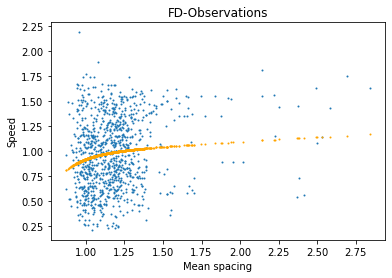

In [7]:
# to stop the computation when model is at its cap
callback = EarlyStopping(monitor='loss', patience=10)  # default on val_loss

# train the FD model
model = FD_Network()
model.compile(optimizer='adam', loss='mse', run_eagerly=True)
model.fit(x=fd_data, y=fd_targets, epochs=50, verbose=2, callbacks=[callback])

# generate the FD speeds with prediction
mean_spacings = fd_data
fd_speeds = model.predict(x=mean_spacings)
model.mse = np.mean((fd_speeds-fd_targets)**2)


# plot the FD prediction over the observations
plt.scatter(fd_data, fd_targets, s=1)  # original data
plt.scatter(mean_spacings, fd_speeds, c='orange', s=1)  # fd model data
plt.xlabel("Mean spacing")
plt.ylabel("Speed")
plt.title("FD-Observations")
plt.show()

### VISUALIZE PARAMETERS FITTING EFFECT BATCH AFTER BATCH (FIT ON OBSERVATIONS)

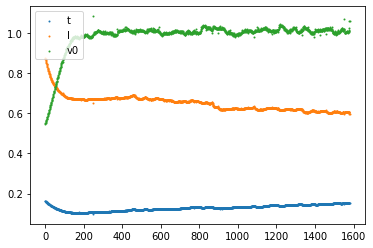

In [33]:
fd1_params = model.FD_model_parameters
fd1_params['t'] = np.array([model.FD_model_parameters['t'][i] for i in range(len(model.FD_model_parameters['t']))]).flatten()
fd1_params['l'] = np.array([model.FD_model_parameters['l'][i] for i in range(len(model.FD_model_parameters['l']))]).flatten()
fd1_params['v0'] = np.array([model.FD_model_parameters['v0'][i] for i in range(len(model.FD_model_parameters['v0']))]).flatten()

plt.scatter(range(fd1_params['t'].shape[0]), fd1_params['t'], s=1, label='t')
plt.scatter(range(fd1_params['l'].shape[0]), fd1_params['l'], s=1, label='l')
plt.scatter(range(fd1_params['v0'].shape[0]), fd1_params['v0'], s=1, label='v0')
plt.legend()
plt.show()


### CREATE PREDICTIONS  AND FIT AN FD MODEL ON THEM

Training the NN model..
Epoch 1/1000
31/31 [==============================] - 0s 862us/step - loss: 1.9328
Epoch 2/1000
31/31 [==============================] - 0s 860us/step - loss: 1.6449
Epoch 3/1000
31/31 [==============================] - 0s 933us/step - loss: 1.3961
Epoch 4/1000
31/31 [==============================] - 0s 880us/step - loss: 1.1754
Epoch 5/1000
31/31 [==============================] - 0s 895us/step - loss: 0.9880
Epoch 6/1000
31/31 [==============================] - 0s 944us/step - loss: 0.8304
Epoch 7/1000
31/31 [==============================] - 0s 884us/step - loss: 0.6944
Epoch 8/1000
31/31 [==============================] - 0s 856us/step - loss: 0.5748
Epoch 9/1000
31/31 [==============================] - 0s 881us/step - loss: 0.4766
Epoch 10/1000
31/31 [==============================] - 0s 979us/step - loss: 0.3986
Epoch 11/1000
31/31 [==============================] - 0s 876us/step - loss: 0.3343
Epoch 12/1000
31/31 [==============================] - 0s 1ms

<ipython-input-37-a53eb7942b5c>:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


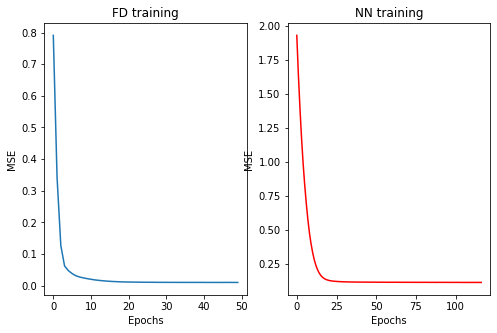

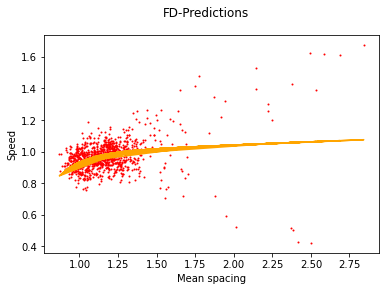

In [37]:
fd_data, fd_targets = read_dataset(data_path, fd_training=True)
nn_data, nn_targets = read_dataset(data_path, fd_training=False)


# to stop the computation when model is at its cap
callback = EarlyStopping(monitor='loss', patience=10)  # default on val_loss

hidden_dims = (3,)

# train the speed predictor neural network
print("Training the NN model..")
nn = create_nn(hidden_dims, dropout=-1)
nn.compile(optimizer='adam', loss='mse')
hist = nn.fit(x=nn_data, y=nn_targets, epochs=1000, callbacks=[callback], verbose=1)
loss_nn = hist.history['loss']

# create the speed for FD to learn
nn_speeds = nn.predict(x=nn_data)

# train the FD model
print("Training the FD model..")
model2 = FD_Network()
model2.compile(optimizer='adam', loss='mse', run_eagerly=True)
hist = model2.fit(x=fd_data, y=nn_speeds, epochs=50, callbacks=[callback], verbose=1)
loss_fd = hist.history['loss']

# training plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
# FD
ax[0].plot(loss_fd)
ax[0].set_title("FD training")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("MSE")
# NN
ax[1].plot(loss_nn, c='red')
ax[1].set_title("NN training")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("MSE")
fig.show()

# plot
mean_spacings = fd_data
fd_speeds = model2.predict(x=mean_spacings)
model2.mse = np.mean((fd_speeds-fd_targets)**2)
fig, ax = plt.subplots(1, 1)
ax.scatter(mean_spacings, fd_speeds, c='orange', s=1)
ax.scatter(nn_data[:, 0], nn_speeds, s=1, c='red')
ax.set_xlabel("Mean spacing")
ax.set_ylabel("Speed")
fig.suptitle("FD-Predictions")
plt.show()

### VISUALIZE PARAMETERS FITTING EFFECT BATCH AFTER BATCH (FIT ON PREDICTIONS)

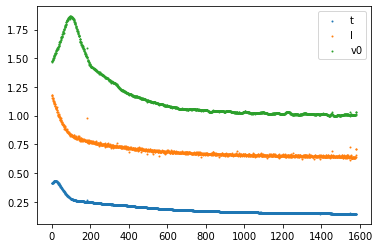

In [40]:
fd2_params = model2.FD_model_parameters
fd2_params['t'] = np.array([model2.FD_model_parameters['t'][i] for i in range(len(model2.FD_model_parameters['t']))]).flatten()
fd2_params['l'] = np.array([model2.FD_model_parameters['l'][i] for i in range(len(model2.FD_model_parameters['l']))]).flatten()
fd2_params['v0'] = np.array([model2.FD_model_parameters['v0'][i] for i in range(len(model2.FD_model_parameters['v0']))]).flatten()

plt.scatter(range(fd2_params['t'].shape[0]), fd2_params['t'], s=1, label='t')
plt.scatter(range(fd2_params['l'].shape[0]), fd2_params['l'], s=1, label='l')
plt.scatter(range(fd2_params['v0'].shape[0]), fd2_params['v0'], s=1, label='v0')
plt.legend()
plt.show()


### COMPARE RESULTS

In [50]:
fd1_t = round(np.mean(fd1_params['t'][1000:]),3)
fd1_l = round(np.mean(fd1_params['l'][1000:]),3)
fd1_v0 = round(np.mean(fd1_params['v0'][1000:]),3)
fd2_t = round(np.mean(fd2_params['t'][1000:]),3)
fd2_l = round(np.mean(fd2_params['l'][1000:]),3)
fd2_v0 = round(np.mean(fd2_params['v0'][1000:]),3)

In [53]:
fd1_t, fd2_t

(0.142, 0.15)

In [54]:
fd1_l, fd2_l

(0.616, 0.649)

In [55]:
fd1_v0, fd2_v0

(1.013, 1.015)